In [1]:
import time
from pylab import *
from ipywidgets import interact
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
import numpy as np
import scipy as sp
import warnings
warnings.filterwarnings('ignore')

from IPython.display import clear_output, HTML, display, Image

0.043000000000000003


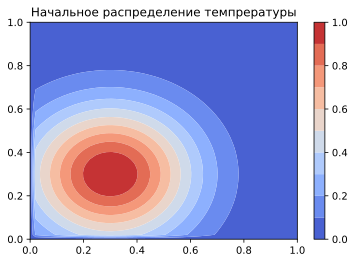

0.125


In [72]:
# Задание параметров
Lx = Ly = 1.0; Lz=0.1;
T = 0.1
Nx = 50
Ny = 50
Nz = 50
Nt = 100
dx = Lx / Nx
dy = Ly / Ny
dz = Lz / Nz
dt = T / Nt
print(dx+dy+dt+dz)
Dxx = 1/dx**2; Dyy = 1/dy**2; Dzz=1/dz**2;
X = np.linspace(0, Lx, Nx);
Y = np.linspace(0, Ly, Ny);
Z = np.linspace(0, Lz, Nz);
Tset = np.linspace(0, T, Nt);
# Функция, реализующая явную разностную схему для уравнения теплопроводности
def solve_layer(u, a, f, dt, dx, dy, dz):
    unew = u.copy()
    Nx, Ny, Nz = u.shape
    for k in range(1, Nz - 1):
        for j in range(1, Ny - 1):
            for i in range(1, Nx - 1):
                unew[i, j, k] = u[i, j, k] + dt * (
                    a * (
                        (u[i+1, j, k] - 2*u[i, j, k] + u[i-1, j, k]) * Dxx + 
                        (u[i, j+1, k] - 2*u[i, j, k] + u[i, j-1, k]) * Dyy + 
                        (u[i, j, k+1] - 2*u[i, j, k] + u[i, j, k-1]) * Dyy
                    ) + f[i, j, k]
                )

    # Update Newman conditions
    unew[0, :, :] = unew[1, :, :];
    unew[-1, :, :] = unew[-2, :, :];
    unew[:, 0, :] = unew[:, 1, :];
    unew[:, -1, :] = unew[:, -2, :];
    unew[:, :, 0] = unew[:, :, 1];
    unew[:, :, -1] = unew[:, :, -2];
    return unew


# Инициализация начальных условий
# Sorce of heat
def f(x, y, z, t):
    if (np.abs(x)>0.7 and np.abs(y)>0.7 and np.abs(z)<0.3): 
        return 5+t
    return 0

def F(TT, dx, dy, dz):
    F_vals = np.zeros((Nt, Nx, Ny, Nz))
    for i in range (1, Nx - 1):
        for j in range(1, Ny-1):
            for k in range(1, Nz-1):
                xi = i*dx; yj = j*dy; zk = k*dz
                F_vals[:, i, j, k] = f(xi, yj, zk, Tset)

    return F_vals
F_vals = F(Tset, dx, dy, dz)
#print(F_vals)
# Initial conditions
u0 = np.zeros((Nx, Ny, Nz))
for i in range(1, Nx-1):
    for j in range(1, Ny-1):
        u0[i, j, 0:-20] = np.exp(-((X[i]-0.3)**2 + (Y[j]-0.3)**2)/0.1)

cp1=contourf(X,Y,u0[:, :, 1],10,cmap='coolwarm')
colorbar()
title("Начальное распределение темпрературы")
#cp1=contour(X,Y,U[k, :, :, n],10,colors='k')
#clabel(cp1,inline=True, fontsize=10)
show()
#print(f)
# Функция для визуализации результата в виде тепловой карты
def solve():
    U = np.zeros((Nt, Nx, Ny, Nz))
    #U[:, 0, :, :] = U[:, -1, :, :] = U[:, :, 0, :] = U[:, :, -1, :] = U[:, :, :, 0] = U[:, :, :, -1]
    u = np.copy(u0)
    U[0] = u0
    for n in range(1, Nt):
        clear_output(wait = True)
        print(f'Progress: {round(n/(Nt), 2)*100}%')  
        u = solve_layer(u, a, F_vals[n], dt, dx, dy, dz)
        U[n] = u
    return U

print(a*dt/dx**2)

In [73]:
U = solve()

Progress: 99.0%


In [77]:
# Невязка
U_t = (U[1:, 1:-1, 1:-1, 1:-1] - U[:-1, 1:-1, 1:-1, 1:-1])/dt
U_xx = (U[:-1, 2:, 1:-1, 1:-1] - 2*U[:-1, 1:-1, 1:-1, 1:-1] + U[:-1, :-2, 1:-1, 1:-1])*Dxx
U_yy = (U[:-1, 1:-1, 2:, 1:-1] - 2*U[:-1, 1:-1, 1:-1, 1:-1] + U[:-1, 1:-1, :-2, 1:-1])*Dyy
U_zz = (U[:-1, 1:-1, 1:-1, 2:] - 2*U[:-1, 1:-1, 1:-1, 1:-1] + U[:-1, 1:-1, 1:-1, :-2])*Dzz
dU = np.abs(U_t - a*(U_xx+U_yy+U_zz) - F_vals[:-1, 1:-1, 1:-1, 1:-1])

In [78]:
# Создание интерактивного интерфейса
def displayZT(n, k, X, Y, U, dU):
    fig, (ax, ay) = plt.subplots(1, 2, figsize=(12, 7)) 
    ax.set_title("Solution")
    ay.set_title("Невязка")
    n = int(round(n/100*Nz, 0))
    if n>Nz-1:
        n = Nz-2
    k = int(round(k/100*Nt, 0))
    if k>Nt-1:
        k = Nt-2
    fig.suptitle(f"t={Tset[k]}\nz={Z[n]}")
    cp1=ax.contourf(X,Y,U[k, :, :, n],10,cmap='coolwarm')
    #plt.colorbar(cp1)
    cp1=ax.contour(X,Y,U[k, :, :, n],10,colors='k')
    plt.clabel(cp1,inline=True, fontsize=10)
    cp2=ay.contourf(X[1:-1],Y[1:-1],dU[k, :, :, n],10,cmap='hot')
    #colorbar(cp2)
    cp2=ay.contour(X[1:-1],Y[1:-1],dU[k, :, :, n],10,colors='k')
    plt.clabel(cp2,inline=True, fontsize=10)
    show()

from ipywidgets import interact
def var(n, k):
    displayZT(n, k, X, Y, U, dU)

interact(var, n=(0, 100, 1), k=(0, 100, 1))

interactive(children=(IntSlider(value=50, description='n'), IntSlider(value=50, description='k'), Output()), _…

<function __main__.var(n, k)>